# Задание для стажировки VK ML-engineer 

Требуется сделать бинарный классификатор определения спам-сообщений

## Подключение библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE

from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import MultinomialNB

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hamnu_cpihx4b\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Загрузка данных

In [3]:
try:
    train = pd.read_csv('train_spam.csv')
    test = pd.read_csv('test_spam.csv')
except:
    print('Ошибка в пути к файлам') 

In [4]:
train.head()

,text_type,text
0,ham,make sure alex knows his birthday is over in f...
1,ham,a resume for john lavorato thanks vince i will...
2,spam,plzz visit my website moviesgodml to get all m...
3,spam,urgent your mobile number has been awarded wit...
4,ham,overview of hr associates analyst project per ...


In [5]:
test.head()

,text
0,j jim whitehead ejw cse ucsc edu writes j you ...
1,original message from bitbitch magnesium net p...
2,java for managers vince durasoft who just taug...
3,there is a youtuber name saiman says
4,underpriced issue with high return on equity t...


## Первичный анализ данных

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16278 entries, 0 to 16277
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text_type  16278 non-null  object
 1   text       16278 non-null  object
dtypes: object(2)
memory usage: 254.5+ KB


In [7]:
train.isnull().sum()

text_type    0
text         0
dtype: int64

In [8]:
train.groupby('text_type').count()

,text
text_type,
ham,11469
spam,4809


In [9]:
train['text_type'] = train['text_type'].apply(lambda x: 0 if x == 'ham'else 1)

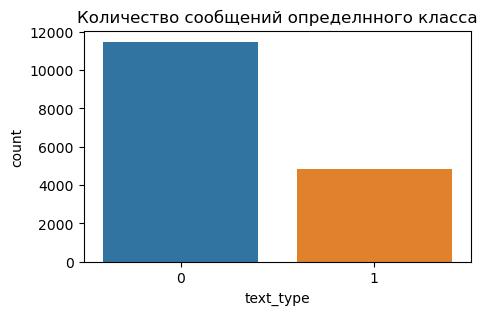

In [10]:
fig = plt.figure(figsize=(5,3))
sns.countplot(train, x = 'text_type')
plt.title('Количество сообщений определнного класса')
plt.show()

В данных наблюдается дисбаланс классов, для его устранения будет использован SMOTE

## Обработка текста

In [11]:
stop_words = stopwords.words('english')
print(stop_words[::10])

porter = PorterStemmer()

['i', "you've", 'himself', 'they', 'that', 'been', 'a', 'while', 'through', 'in', 'here', 'few', 'own', 'just', 're', 'doesn', 'ma', "shouldn't"]


In [12]:
def clean_text(words):
    words = re.sub("[^a-zA-Z]"," ", words)
    text = words.lower().split()                   
    return " ".join(text)

def remove_stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in stop_words]
    return " ".join(text)

def stemmer(stem_text):
    stem_text = [porter.stem(word) for word in stem_text.split()]
    return " ".join(stem_text)

In [13]:
train['text'] = train['text'].apply(clean_text)
train['text'] = train['text'].apply(remove_stopwords)
train['text'] = train['text'].apply(stemmer)

In [14]:
train.head()

,text_type,text
0,0,make sure alex know birthday fifteen minut far...
1,0,resum john lavorato thank vinc get move right ...
2,1,plzz visit websit moviesgodml get movi free al...
3,1,urgent mobil number award prize guarante call ...
4,0,overview hr associ analyst project per david r...


## Создание модели

### Векторизация через мешок слов

In [15]:
X = train['text']
y = train['text_type']

In [16]:
vect = CountVectorizer(min_df=5, ngram_range=(1,2)).fit(X)
X_vec = vect.transform(X)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.3, stratify=y,random_state=1)

### Исбавление от дисбаланса классов

In [18]:
smote = SMOTE()

In [19]:
X_train, y_train = smote.fit_resample(X_train, y_train)

### Построение моделей

Для рассмотрения будут использованы следующие модели:
1. Логистическая регрессия
2. Дерево решений
3. Градиентный бустинг
4. Наивный байес

#### Логистическая регрессия

In [21]:
logic_model = LogisticRegression()
pipe_logic = Pipeline([('tfidf', TfidfTransformer()),
                   ('model',logic_model)])
params = {'model__penalty' : ['l1', 'l2', 'elasticnet'],
         'model__C' : [0.1, 0.5, 1.0, 1.5],
         'model__random_state' : [1]
         }

In [22]:
logic_cv = GridSearchCV(pipe_logic, params, scoring='f1', cv=4)
logic_cv.fit(X_train, y_train)

print('Лучший скор модели: ', logic_cv.best_score_)
print('Параметры модели: ', logic_cv.best_params_)

Лучший скор модели:  0.9085242522350236<br>
Параметры модели:  {'model__C': 1.5, 'model__penalty': 'l2', 'model__random_state': 1}

#### Дерево решений

In [23]:
tree_model = DecisionTreeClassifier()
pipe_tree = Pipeline([('tfidf', TfidfTransformer()),
                   ('model',tree_model)])
params = {'model__criterion' : ['gini', 'entropy', 'log_loss'],
          'model__max_depth' : range(1, 15, 2),
          'model__random_state' : [1]
         }

tree_cv = GridSearchCV(pipe_tree, params, scoring='f1', cv=4)
tree_cv.fit(X_train, y_train)

print('Лучший скор модели: ', tree_cv.best_score_)
print('Параметры модели: ', tree_cv.best_params_)

Лучший скор модели:  0.7712408945556224<br>
Параметры модели:  {'model__criterion': 'gini', 'model__max_depth': 13, 'model__random_state': 1}

#### Градиентный бустинг

In [24]:
cat_model = CatBoostClassifier(silent=True)
pipe_cat = Pipeline([('tfidf', TfidfTransformer()),
                   ('model',cat_model)])
params = {'model__learning_rate' : [0.1, 0.5, 1],
          'model__depth' : range(2, 5, 2)
         }

cat_cv = GridSearchCV(pipe_cat, params, scoring='f1', cv=4)
cat_cv.fit(X_train, y_train)

print('Лучший скор модели: ', cat_cv.best_score_)
print('Параметры модели: ', cat_cv.best_params_)

Лучший скор модели:  0.9021162587458407<br>
Параметры модели:  {'model__depth': 4, 'model__learning_rate': 0.5}

#### Наивный байес

In [25]:
nb_model = MultinomialNB()
pipe_nb = Pipeline([('tfidf', TfidfTransformer()),
                   ('model',nb_model)])

params = {'model__alpha' : [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 1.0]}

nb_cv = GridSearchCV(pipe_nb, params, scoring='f1', cv=4)
nb_cv.fit(X_train, y_train)

print('Лучший скор модели: ', nb_cv.best_score_)
print('Параметры модели: ', nb_cv.best_params_)

Лучший скор модели:  0.803037796998812
Параметры модели:  {'model__alpha': 0.1}


Лучший скор модели:  0.7978032052407218<br>
Параметры модели:  {'model__alpha': 0.1}

## Выбор модели

In [26]:
model_logic = pipe_logic.set_params(model__C=1.5, model__penalty='l2')
model_logic.fit(X_train, y_train)
f1_logic = f1_score(model_logic.predict(X_test), y_test)

In [27]:
model_tree = pipe_tree.set_params(model__criterion='gini', model__max_depth=13)
model_tree.fit(X_train, y_train)
f1_tree = f1_score(model_tree.predict(X_test), y_test)

In [28]:
model_cat = pipe_cat.set_params(model__depth=4, model__learning_rate=0.5)
model_cat.fit(X_train, y_train)
f1_cat = f1_score(model_cat.predict(X_test), y_test)

In [29]:
model_nb = pipe_nb.set_params(model__alpha=0.1)
model_nb.fit(X_train, y_train)
f1_nb = f1_score(model_nb.predict(X_test), y_test)

In [30]:
result_tab = pd.DataFrame(index=['Логистическая регрессия', 'Дерево решений', 'Градиентный бустинг', 'Наивный байес'], data=[f1_logic, f1_tree, f1_cat, f1_nb], columns=['f1'])
result_tab.sort_values(by='f1', ascending=False)

,f1
Наивный байес,0.828120
Градиентный бустинг,0.815725
Логистическая регрессия,0.814143
Дерево решений,0.585325


Наилучший результат на тестовой выборке показал наивный байес с f1 метрикой 0.82963 с гиперпараметрами alpha=0.1

## Результат

In [31]:
test['text'] = test['text'].apply(clean_text)
test['text'] = test['text'].apply(remove_stopwords)
test['text'] = test['text'].apply(stemmer)

In [34]:
X_test = vect.transform(test['text'])

In [33]:
smote = SMOTE()
X, y = smote.fit_resample(X_vec, y)

In [35]:
res_model = pipe_nb.set_params(model__alpha=0.1)
res_model.fit(X, y)

Pipeline(steps=[('tfidf', TfidfTransformer()),
                ('model', MultinomialNB(alpha=0.1))])

In [36]:
y_test = res_model.predict(X_test)

In [45]:
np.savetxt('predict.csv', y_test, fmt="%d", delimiter=',')

In [46]:
test['score'] = y_test

In [51]:
test.to_csv('test_predict.csv')